### Clouds : test clouds 3D with NEXT MC Beersheba events

J. A Hernando, M. Pérez

January 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

import clouds.mc_clouds as mcclouds

import invisible_cities.io.dst_io as dio

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [4]:
from utils.plotting_utils import plot_cloud_voxels, plot_cloud_voxels_and_hits, plot_3d_hits

In [5]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed Jan 19 20:32:36 2022


In [6]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/"
filenames = ("Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5", 
             "Tl208_NEW_v1_03_01_nexus_v5_03_04_cut25.beersheba_label_4mm_fid.h5")
filenames = [datadir+file for file in filenames]
print('total files', len(filenames))
print(filenames[0])

total files 2
/Users/hernando/work/investigacion/NEXT/data/MC/NEW/ds/Tl208_NEW_v1_03_01_nexus_v5_03_04_cut24.beersheba_label_4mm_fid.h5


In [8]:
def get_dfs(filename):
    
    dfs = {}
    
    dfs['rcvoxels'] = dio.load_dst(filename, 'DATASET', 'BeershebaVoxels')
    dfs['mcvoxels'] = dio.load_dst(filename, 'DATASET', 'MCVoxels')
    dfs['mchits']   = dio.load_dst(filename, 'DATASET', 'MCHits')
    dfs['events']   = dio.load_dst(filename, 'DATASET', 'EventsInfo')
    dfs['bins']     = dio.load_dst(filename, 'DATASET', 'BinsInfo')
    
    return dfs

In [15]:
dfs = get_dfs(filenames[0])

In [16]:
rcvoxels   = dfs['rcvoxels']
mchits     = dfs['mchits']
voxel_size = [float(dfs['bins'][var].unique()) for var in ('size_x', 'size_y', 'size_z')]
print(voxel_size)

[5.0, 5.0, 4.0]


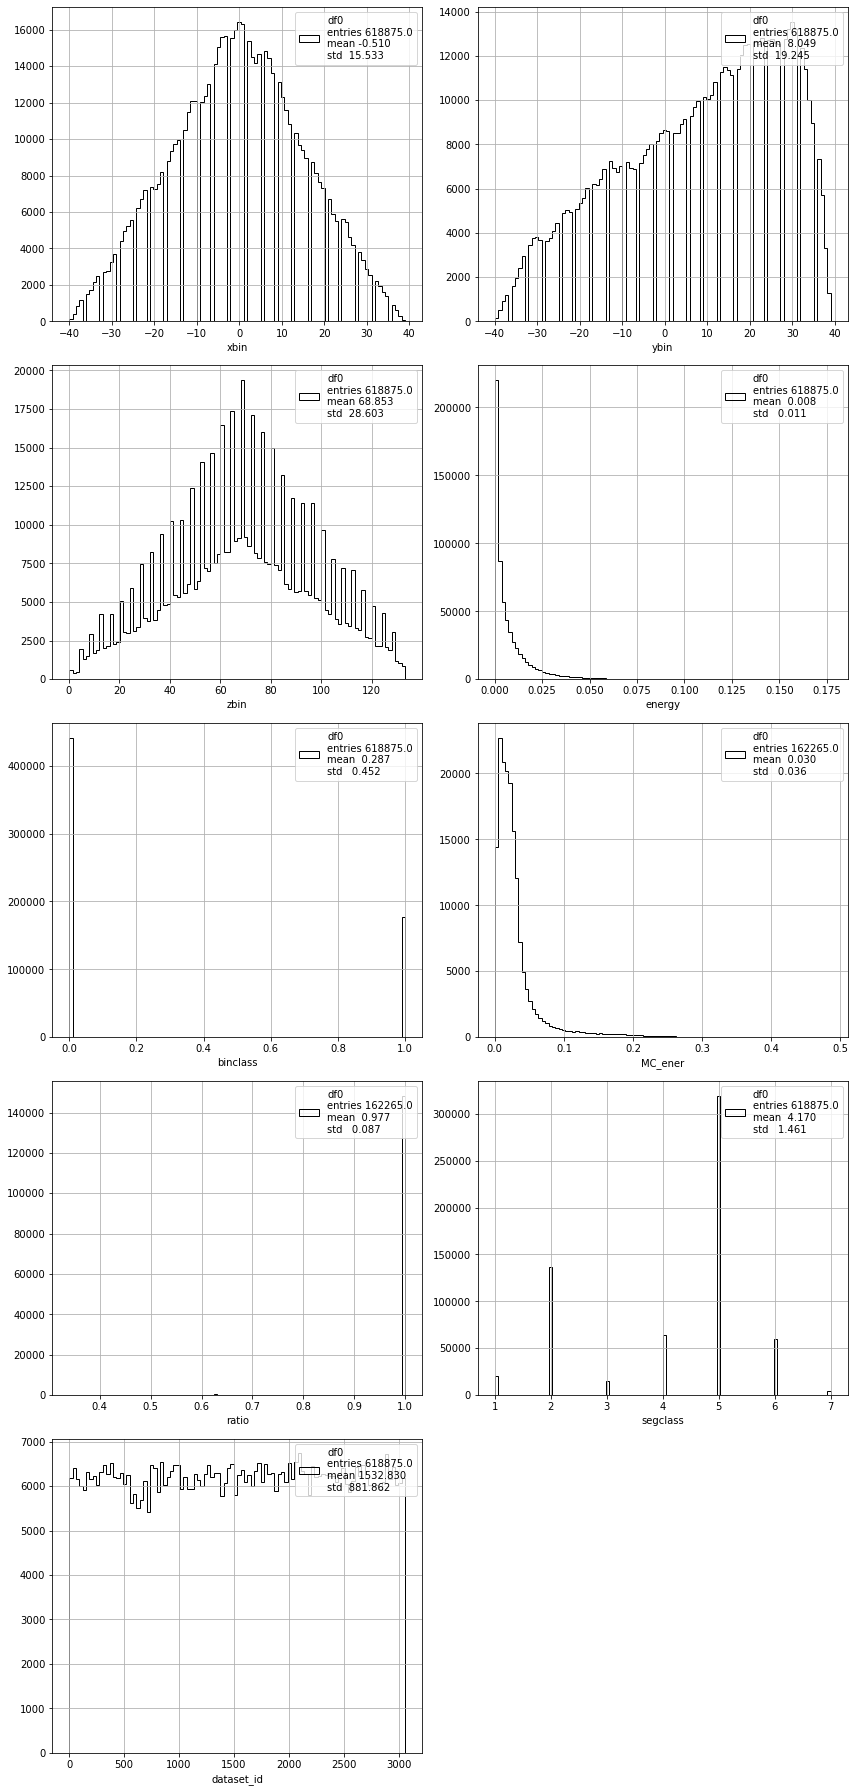

In [17]:
pltext.df_inspect(rcvoxels)

In [18]:
## List of events
single_e = [27,]
single_e_xray = [0,]
problematic = [1,]

In [113]:
events = rcvoxels['dataset_id'].unique()
event  = events[9]
# single 27

In [114]:
# The binclass == 0 indicates single-e, 1, double-electron

evoxels    = rcvoxels[rcvoxels.dataset_id == event]
ehits      = mchits  [mchits  .dataset_id == event]
edataclass = int(evoxels.binclass.unique())

print('Event :', event, ', class : ', edataclass)

Event : 9 , class :  1


<IPython.core.display.Javascript object>


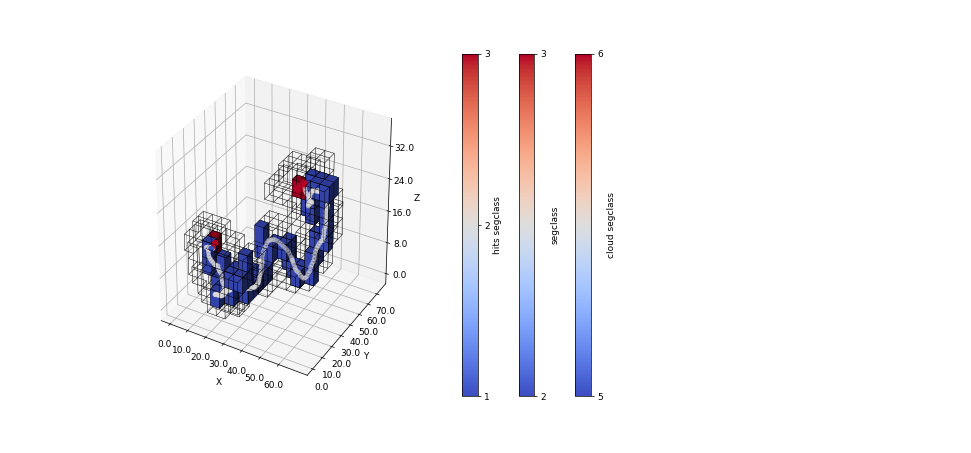

In [115]:
%matplotlib notebook
plot_cloud_voxels_and_hits(evoxels, ehits, voxel_size, opacity = [1., 0.001])
#plot_3d_hits(ehits, voxel_size, opacity = [0.5])

## Create clouds

In [116]:
steps  = voxel_size
print(steps)
coors  = [evoxels[var].values for var in ('xbin', 'ybin', 'zbin')]
coors  = [size * coor for size, coor in zip(voxel_size, coors)]
ene    = evoxels['energy'].values
bins, mask, cells, cloud = clouds.clouds(coors, steps, ene)

[5.0, 5.0, 4.0]


In [117]:
# add segmentation in cloud
cloud['segclass'] = evoxels['segclass'].values

<IPython.core.display.Javascript object>


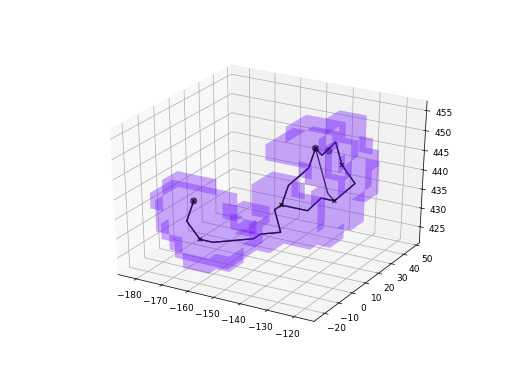

In [118]:
%matplotlib notebook
cells_select = clouds.cells_select
plt.figure(figsize = (8, 6))
pltclouds.draw_cloud(cells, bins, cloud);
ax = plt.gca()
seg_blob = 3
sel = cloud['segclass'] == seg_blob
ax.scatter(*cells_select(cells, sel), marker = 'o', c = 'black', s = 50, alpha = 0.5);

In [119]:
cloud.columns

Index(['vgrad', 'lap', 'l1', 'vphi', 'l0', 'e0phi', 'ge0', 'ge1', 'l2', 'ge2',
       'vtheta', 'e0theta', 'x0', 'x1', 'x2', 'energy', 'neighbours', 'kid',
       'iscore', 'einten', 'egrad', 'epath', 'egradrel', 'epathrel', 'elgrad',
       'elink', 'enode', 'eisnode', 'eisborder', 'eidborder', 'eispass',
       'eisridge', 'pinten', 'pgrad', 'ppath', 'pgradrel', 'ppathrel',
       'plgrad', 'plink', 'pnode', 'pisnode', 'pisborder', 'pidborder',
       'pispass', 'pisridge', 'segclass'],
      dtype='object')

In [120]:
# Test that coords (from voxels) and cells are the same!!
len(coors[0]), len(cells[0])
assert np.sum(coors[2] - cells[2]) == 0

In [121]:
## What is the node area of the blob voxels
sel = cloud['segclass'] == seg_blob
blob_nodes      = cloud['enode'][sel].unique()
blob_cell_nodes = (cloud['eisnode'] == True) & (cloud['segclass'] == seg_blob)
print('blob nodes ', blob_nodes)
print('blob nodes cell ', np.sum(blob_cell_nodes), cloud['kid'][blob_cell_nodes].values)

blob nodes  [ 22 135]
blob nodes cell  2 [ 22 135]


In [122]:
# plot the energy of the node cells by segmentation
#seg_labels = ['null', 'other', 'track', 'blob', 'o-neighbour', 't-neighbour', 'b-neighbour', 'ghost']
#%matplotlib inline
#plt.figure(figsize = (8, 6));
#for i in [1, 2, 3, 4, 5, 6, 7]:
#    xsel = cloud['segclass'] == i
#    if (np.sum(xsel) > 0):
#        print(i, seg_labels[i], np.sum(xsel), np.mean(cloud.energy[xsel]), np.max(cloud.energy[xsel]))
#        pltext.hist(cloud.energy[xsel], 20, (0., 0.05), fill = True, alpha = 0.5, label = seg_labels[i]);

2 track 48 0.011442231453406051 0.0001781277130264498 0.034523993953236944
3 blob 3 0.03563476990424571 0.027376054024244756 0.040067827997081855
5 t-neighbour 126 0.005625388563729903 0.000176148156320046 0.03115619536831678
6 b-neighbour 35 0.007677615633136208 0.0003659708446017896 0.02808197759414565


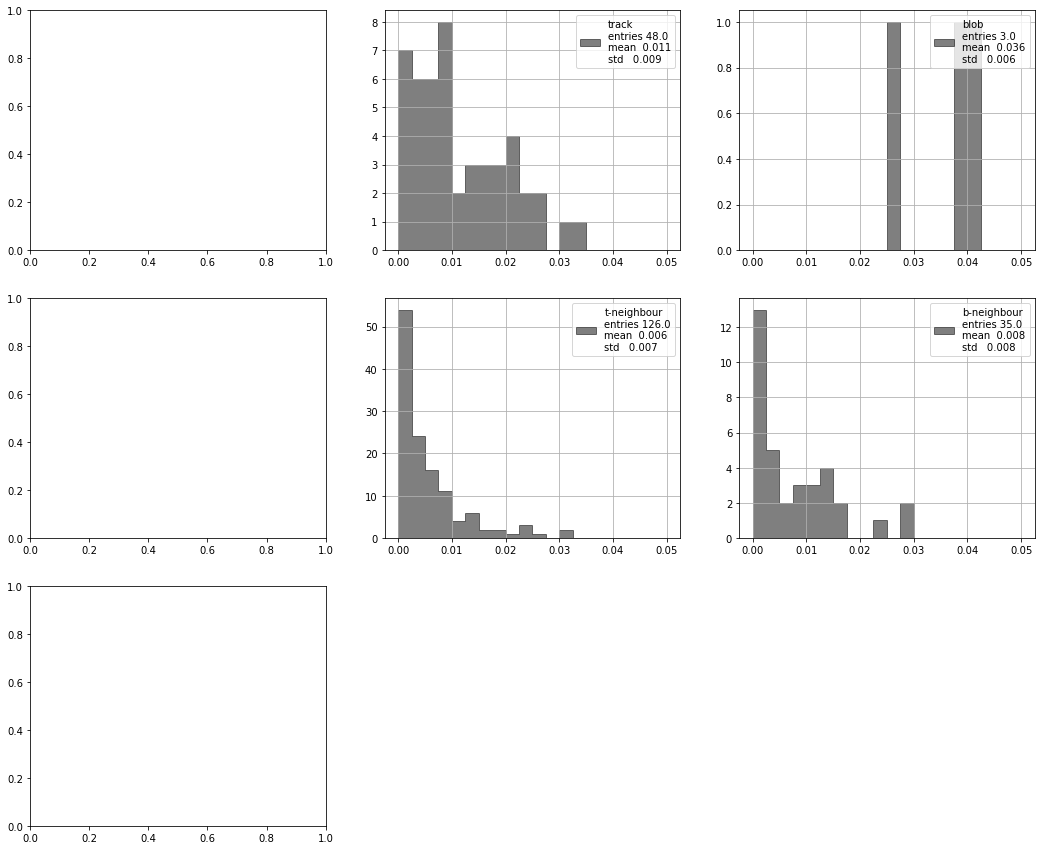

In [123]:
%matplotlib inline
seg_labels = ['null', 'other', 'track', 'blob', 'o-neighbour', 't-neighbour', 'b-neighbour', 'ghost']

cd = pltext.canvas(7, 3);
for i in [1, 2, 3, 4, 5, 6, 7]:
    cd(i)
    xsel = cloud['segclass'] == i
    if (np.sum(xsel) > 0):
        print(i, seg_labels[i], np.sum(xsel), np.mean(cloud.energy[xsel]),
              np.min(cloud.energy[xsel]), np.max(cloud.energy[xsel]))
        stats = np.sum(xsel) > 1
        pltext.hist(cloud.energy[xsel], 20, (0., 0.05), fill = True, alpha = 0.5, label = seg_labels[i],
                    stats = stats);

In [124]:
# create a DF with the nodes information
nodes         = cloud['enode'].unique()
nodes_seg     = np.array([int(cloud['segclass'][node]) for node in nodes])
nodes_isblob  = np.isin(nodes, blob_nodes)
nodes_size    = np.array([np.sum(cloud['enode'] == node) for node in nodes])
nodes_energy  = np.array([np.sum(cloud[cloud['enode'] == node].energy) for node in nodes])
nodes_enecell = np.array([float(cloud['energy'][node]) for node in nodes])

def blob_order(vals, nodes):
    vals, pos = clouds.ut_sort(vals, nodes)
    ipos = [int(np.where(pos == node)[0]) for node in nodes]
    return ipos 

nodes_osize    = blob_order(nodes_size   , nodes)
nodes_oenergy  = blob_order(nodes_energy , nodes)
nodes_oenecell = blob_order(nodes_enecell, nodes)

nnodes  = len(nodes)
dfnodes = pd.DataFrame()
dfnodes['dataset_id'] = np.ones(nnodes, int) * event
dfnodes['dataclass']  = np.ones(nnodes, int) * edataclass
dfnodes['nodes']     = nodes
dfnodes['segclass']  = nodes_seg
dfnodes['isblob']    = nodes_isblob
dfnodes['size']      = nodes_size
dfnodes['energy']    = nodes_energy 
dfnodes['enecell']   = nodes_enecell
dfnodes['osize']     = nodes_osize
dfnodes['oenergy']   = nodes_oenergy 
dfnodes['oenecell']  = nodes_oenecell

In [125]:
dfnodes

,dataset_id,dataclass,nodes,segclass,isblob,size,energy,enecell,osize,oenergy,oenecell
0,9,1,22,3,True,37,0.396765,0.040068,3,1,0
1,9,1,33,2,False,53,0.348689,0.026384,0,2,3
2,9,1,103,2,False,41,0.246874,0.030123,2,3,2
3,9,1,135,3,True,51,0.466618,0.039460,1,0,1
4,9,1,180,5,False,9,0.020311,0.010203,5,5,5
5,9,1,186,5,False,21,0.154389,0.026188,4,4,4


In [200]:
### Run over the events in the file
def run(rcvoxels, voxel_size, nevents = -1):

    events = rcvoxels['dataset_id'].unique()
    df     = None 
    nevents = len(events) if nevents == -1 else nevents
    print('events to process ', nevents)
    for evt in events[:nevents]:
        
        evoxels    = rcvoxels[rcvoxels.dataset_id == evt]
        ehits      = mchits  [mchits  .dataset_id == evt]
        edataclass = int(evoxels.binclass.unique())
        if (evt%100 == 0):
            print('Event :', evt, ', class : ', edataclass)
    
        coors  = [evoxels[var].values for var in ('xbin', 'ybin', 'zbin')]
        coors  = [size * coor for size, coor in zip(voxel_size, coors)]
        ene    = evoxels['energy'].values
        bins, mask, cells, cloud = clouds.clouds(coors, steps, ene)
        cloud['segclass'] = evoxels['segclass'].values
    
        sel = cloud['segclass'] == seg_blob
        blob_nodes      = cloud['enode'][sel].unique()
        blob_cell_nodes = (cloud['eisnode'] == True) & (cloud['segclass'] == seg_blob)
        #print('blob nodes ', blob_nodes)
        #print('blob nodes cell ', np.sum(blob_cell_nodes), cloud['kid'][blob_cell_nodes].values)

        # create a DF with the nodes information
        nodes         = cloud['enode'].unique()
        nodes_seg     = np.array([int(cloud['segclass'][node]) for node in nodes])
        nodes_isblob  = np.isin(nodes, blob_nodes)
        nodes_size    = np.array([np.sum(cloud['enode'] == node) for node in nodes])
        nodes_energy  = np.array([np.sum(cloud[cloud['enode'] == node].energy) for node in nodes])
        nodes_enecell = np.array([float(cloud['energy'][node]) for node in nodes])

        def blob_order(vals, nodes):
            vals, pos = clouds.ut_sort(vals, nodes)
            ipos = [int(np.where(pos == node)[0]) for node in nodes]
            return ipos 

        nodes_osize    = blob_order(nodes_size   , nodes)
        nodes_oenergy  = blob_order(nodes_energy , nodes)
        nodes_oenecell = blob_order(nodes_enecell, nodes)

        nnodes  = len(nodes)
        dfnodes = pd.DataFrame()
        dfnodes['dataset_id'] = np.ones(nnodes, int) * evt
        dfnodes['dataclass']  = np.ones(nnodes, int) * edataclass
        dfnodes['blobs']      = np.ones(nnodes, int) * len(blob_nodes)
        dfnodes['nodes']     = np.arange(nnodes)
        dfnodes['segclass']  = nodes_seg
        dfnodes['isblob']    = nodes_isblob
        dfnodes['size']      = nodes_size
        dfnodes['energy']    = nodes_energy 
        dfnodes['enecell']   = nodes_enecell
        dfnodes['osize']     = nodes_osize
        dfnodes['oenergy']   = nodes_oenergy 
        dfnodes['oenecell']  = nodes_oenecell

        #print(dfnodes)
        
        df = dfnodes if df is None else pd.concat((df, dfnodes), ignore_index = True)
    
    return df

In [216]:
df = run(rcvoxels, voxel_size, -1)

events to process  3059
Event : 0 , class :  0
Event : 100 , class :  1
Event : 200 , class :  0
Event : 300 , class :  0
Event : 400 , class :  0
Event : 500 , class :  1
Event : 600 , class :  1
Event : 700 , class :  0
Event : 800 , class :  0
Event : 900 , class :  0
Event : 1000 , class :  1
Event : 1100 , class :  0
Event : 1200 , class :  0
Event : 1300 , class :  0
Event : 1400 , class :  0
Event : 1500 , class :  0
Event : 1600 , class :  1
Event : 1700 , class :  1
Event : 1800 , class :  0
Event : 1900 , class :  0
Event : 2000 , class :  1
Event : 2100 , class :  0
Event : 2200 , class :  1
Event : 2300 , class :  0
Event : 2400 , class :  0
Event : 2500 , class :  0
Event : 2600 , class :  0
Event : 2700 , class :  1
Event : 2800 , class :  0
Event : 2900 , class :  0
Event : 3000 , class :  1


In [217]:
df

,dataset_id,dataclass,blobs,nodes,segclass,isblob,size,energy,enecell,osize,oenergy,oenecell
0,0,0,1,0,7,False,4,0.001160,0.000603,7,7,7
1,0,0,1,1,3,True,32,0.368767,0.064350,3,0,0
2,0,0,1,2,7,False,1,0.000279,0.000279,8,8,8
3,0,0,1,3,1,False,24,0.162141,0.032039,5,4,3
4,0,0,1,4,2,False,19,0.159520,0.029053,6,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
26150,3058,0,1,7,2,False,20,0.094515,0.012257,5,6,9
26151,3058,0,1,8,2,False,14,0.064707,0.018739,7,7,7
26152,3058,0,1,9,7,False,1,0.001043,0.001043,11,11,11
26153,3058,0,1,10,1,False,11,0.029648,0.014524,8,9,8


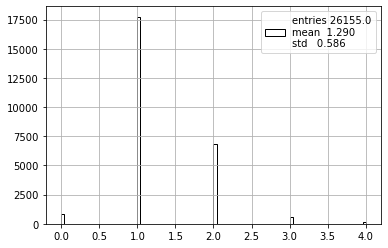

In [218]:
pltext.hist(df['blobs'], 100);

order size  [7.20958084e+01 1.91017964e+01 5.74850299e+00 2.39520958e+00
 5.98802395e-01 5.98802395e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
order energy  [87.24550898 10.77844311  1.85628743  0.11976048  0.          0.
  0.          0.          0.          0.        ]
order energy cell  [8.15568862e+01 1.48502994e+01 3.11377246e+00 4.19161677e-01
 5.98802395e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


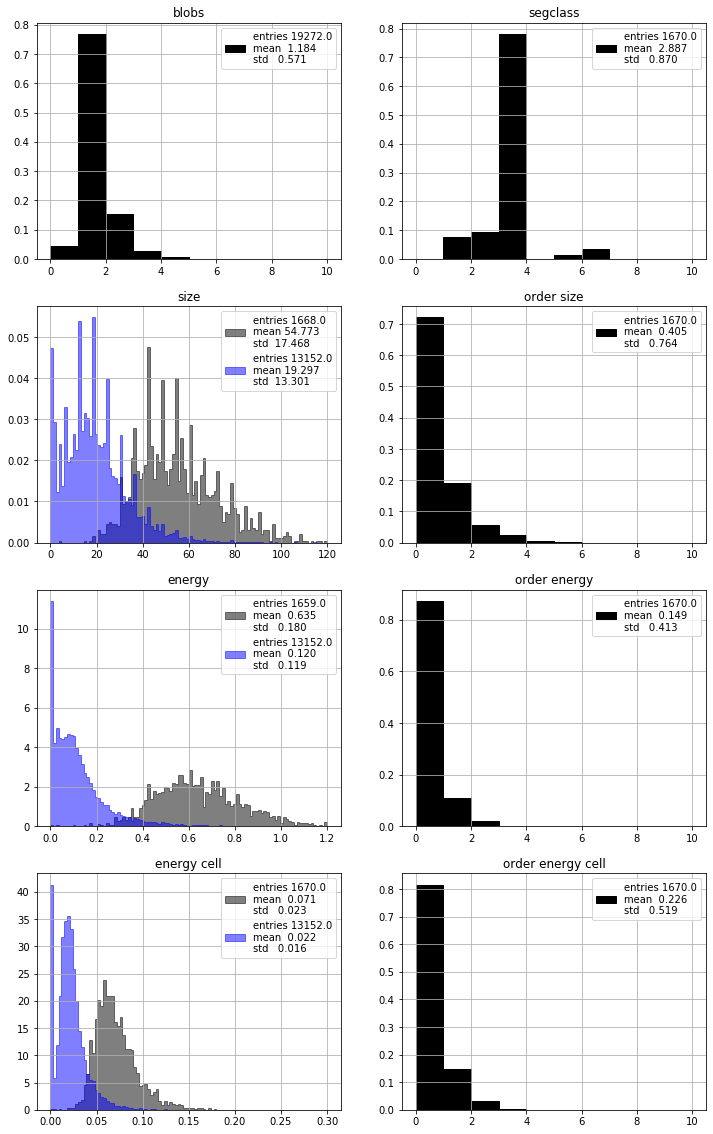

In [221]:
xsel = (df.dataclass == 0) & (df.isblob == True)  & (df.blobs == 1)
ysel = (df.dataclass == 0) & (df.isblob == False) & (df.blobs == 1)
#print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('blobs')
pltext.hist(df['blobs'][df.dataclass == 0], 10, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
cd(4); plt.title('order size');
pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
print('order size ', 100*counts)

cd(5); plt.title('energy');
pltext.hist(df['energy'][xsel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
pltext.hist(df['energy'][ysel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['oenergy'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenergy'][xsel], 10, (0, 10), density = True)
print('order energy ', 100*counts)

cd(7); plt.title('energy cell');
pltext.hist(df['enecell'][xsel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
pltext.hist(df['enecell'][ysel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order energy cell');
pltext.hist(df['oenecell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenecell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)


order size  [42.62877442 34.54706927 14.65364121  5.15097691  1.95381883  0.88809947
  0.17761989  0.          0.          0.        ]
order energy  [46.89165187 42.62877442  8.25932504  1.77619893  0.35523979  0.
  0.08880995  0.          0.          0.        ]
order energy cell  [45.47069272 41.91829485 10.56838366  1.77619893  0.26642984  0.
  0.          0.          0.          0.        ]


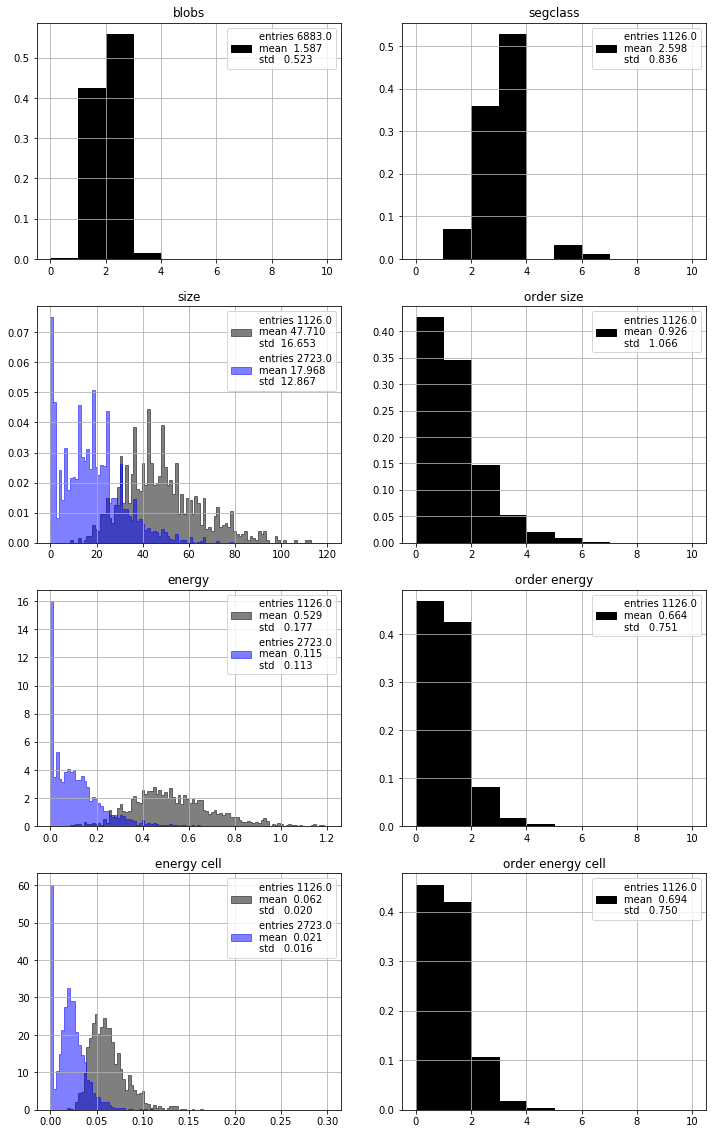

In [222]:
xsel = (df.dataclass == 1) & (df.isblob == True)  & (df.blobs == 2)
ysel = (df.dataclass == 1) & (df.isblob == False) & (df.blobs == 2)
#print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('blobs')
pltext.hist(df['blobs'][df.dataclass == 1], 10, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass')
pltext.hist(df['segclass'][xsel], 10, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
cd(4); plt.title('order size');
pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['osize'][xsel], 10, (0, 10), density = True)
print('order size ', 100*counts)

cd(5); plt.title('energy');
pltext.hist(df['energy'][xsel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
pltext.hist(df['energy'][ysel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['oenergy'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenergy'][xsel], 10, (0, 10), density = True)
print('order energy ', 100*counts)

cd(7); plt.title('energy cell');
pltext.hist(df['enecell'][xsel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
pltext.hist(df['enecell'][ysel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order energy cell');
pltext.hist(df['oenecell'][xsel], 10, (0, 10), density = True, fill = True);
counts, _  = np.histogram(df['oenecell'][xsel], 10, (0, 10), density = True)
print('order energy cell ', 100*counts)


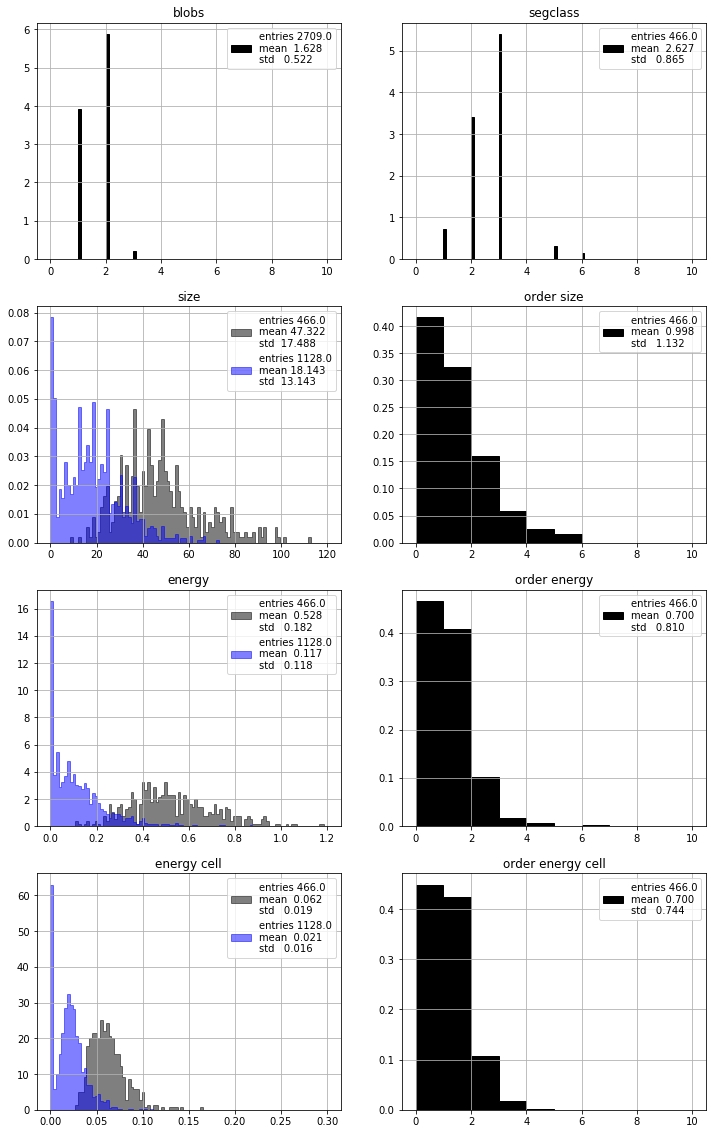

In [215]:
xsel = (df.dataclass == 1) & (df.isblob == True)  & (df.blobs == 2)
ysel = (df.dataclass == 1) & (df.isblob == False) & (df.blobs == 2)
#print(np.sum(xsel), np.sum(ysel)); 
cd = pltext.canvas(7, 2)
cd(1); plt.title('blobs')
pltext.hist(df['blobs'][df.dataclass == 1], 100, (0, 10), density = True, fill = True);
cd(2); plt.title('segclass')
pltext.hist(df['segclass'][xsel], 100, (0, 10), density = True, fill = True); 

cd(3); plt.title('size');
pltext.hist(df['size'][xsel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
pltext.hist(df['size'][ysel], 100, (0, 120), density = True, fill = True, alpha = 0.5);
cd(4); plt.title('order size');
pltext.hist(df['osize'][xsel], 10, (0, 10), density = True, fill = True);

cd(5); plt.title('energy');
pltext.hist(df['energy'][xsel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
pltext.hist(df['energy'][ysel], 100, (0, 1.2), density = True, fill = True, alpha = 0.5);
cd(6); plt.title('order energy');
pltext.hist(df['oenergy'][xsel], 10, (0, 10), density = True, fill = True);

cd(7); plt.title('energy cell');
pltext.hist(df['enecell'][xsel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
pltext.hist(df['enecell'][ysel], 100, (0, 0.3), density = True, fill = True, alpha = 0.5);
cd(8); plt.title('order energy cell');
pltext.hist(df['oenecell'][xsel], 10, (0, 10), density = True, fill = True);

[ 32  76  64 124 171 137 197 211]
[1 2 7 1 2 4 3 4]
here  [ 32  76  64 124 171 137 197 211] [197]
[37 56  2 31 45 27 21  3]
[4.56803277e-01 4.54376022e-01 1.59145451e-04 1.45584212e-01
 4.79280979e-01 2.95986423e-02 2.12696677e-01 1.08923038e-03]


<IPython.core.display.Javascript object>


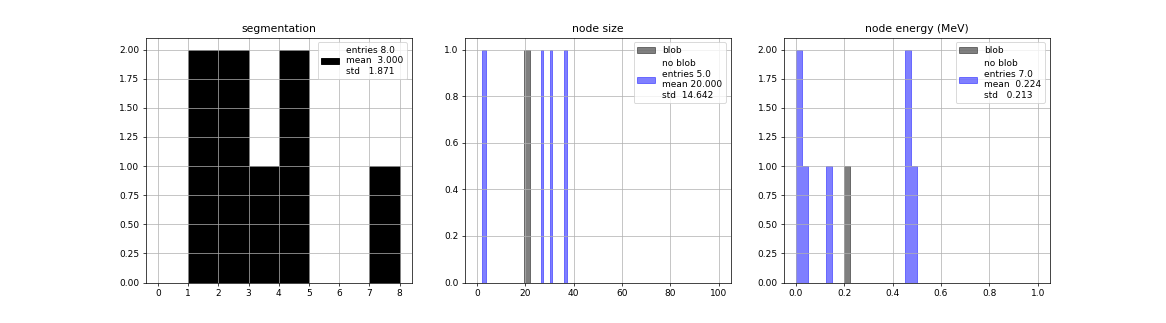

In [263]:
## nodes area: size, energy and segmentation of cell node

## >>>> TODO: consider node blobs those which contain blob voxels

nodes     = cloud['enode'].unique()
nodes_seg = np.array([int(cloud['segclass'][node]) for node in nodes])
#nodes_isblob = np.array(nodes_seg == seg_blob) # the cell node is blob
#print('here ', nodes, nodes_blob)
nodes_isblob = np.array(np.isin(nodes_seg, np.array(nodes_blob)))
#print(nodes_isblob)
nodes_size = np.array([np.sum(cloud['enode'] == node) for node in nodes])
print(nodes_size)
nodes_ene = np.array([np.sum(cloud[cloud['enode'] == node].energy) for node in nodes])
print(nodes_ene)

cd = pltext.canvas(3, 3)
cd(1); 
pltext.hist(nodes_seg, 8, (0, 8), fill = True); plt.title('segmentation')
cd(2); 
#plt.hist(nodes_size[nodes_blob] , 41, (0, 40));
pltext.hist(nodes_size[nodes_isblob] , 41, (0, 100), label = 'blob', fill = True, stats = False, alpha = 0.5);
pltext.hist(nodes_size[~nodes_isblob], 41, (0, 40), label = 'no blob', alpha = 0.5, fill = True);
plt.title('node size');
cd(3); 
pltext.hist(nodes_ene[nodes_isblob] , 40, (0, 1.), label = 'blob', fill = True, stats = False, alpha = 0.5);
pltext.hist(nodes_ene[~nodes_isblob], 40, (0, 1.), label = 'no blob', fill = True, alpha = 0.5);
plt.title('node energy (MeV)');

In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
# events good:  3214
# File number 125 , Event 1252
# filename, event  =  360 ,  3604
# filename, event  =  379 ,  3798
# filename, event  =  25 ,  256


# interesing problematic events
# filename, event  =  190 ,  1902

# Interesting events
# filename, event  =  490 ,  4901
# filename, event  =  449 ,  4493



In [175]:
def get_event(filename = None, event = None):
    filename = np.random.choice(filenames) if filename is None else filename

    CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
    CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

    MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
    data_events = pd.read_hdf(filename, "Run/events")
    event       = np.random.choice(data_events["evt_number"]) if event is None else event
    print('filename, event  = ', get_file_number(filename), ', ', event)
    
    low  = CHITS_lowTh .get_group(event)
    high = CHITS_highTh.get_group(event)
    true = MChits      .get_group(event)

    x, y, z, w = split_hits(low, weight="E")
    coors = (x, y, z)
    ene   = 1e-5 * w

    mcx, mcy, mcz, mcid = true["x"].values, true["y"].values, dv*true["z"].values, true['particle_id'].values
    mccoors = (mcx, mcy, mcz)
    mcene, mctime = true["energy"].values, true['time'].values
    
    print('Energy MC ', np.sum(mcene), ', RC ', np.sum(ene))
    
    if (np.sum(ene) <= 2.1): 
        return get_event()
    
    return coors, ene, mccoors, mcene, mctime, mcid
    

In [176]:
coors, ene, mccoors, mcene, mctime, mcid = get_event()

filename, event  =  93 ,  937
Energy MC  1.3678263 , RC  1.0946381882715226
filename, event  =  74 ,  749
Energy MC  2.4578302 , RC  2.3000968308258054


## Draw MC event

<IPython.core.display.Javascript object>


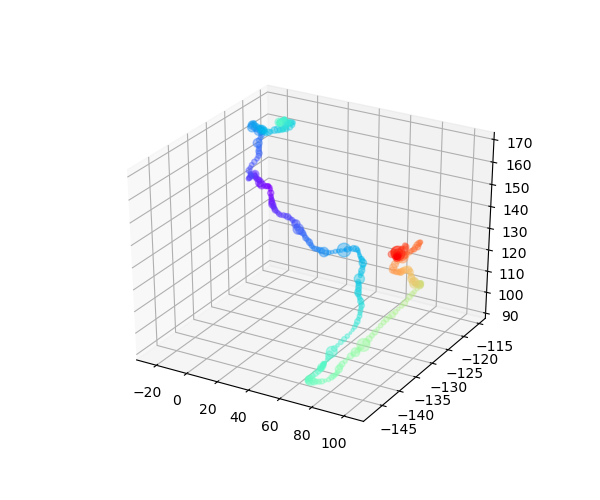

In [177]:
cells_select = clouds.cells_select
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scale  = mctime/np.max(mctime)
size   = mcene/np.max(mcene)
plt.gca().scatter(*mccoors, c = scale, s = 100 * size, marker = 'o', alpha = 0.4);
#for i in np.unique(mcid):
#    sel = mcid == i
#    plt.gca().scatter(*cells_select(mccoors, sel),s = 100 * size[sel], marker = 'o', alpha = 0.4);

In [179]:
#pltclouds.plot_tview(mccoors, mcene, mctime)

## Draw Reco

In [180]:
steps  = (10, 10, 2)
bins, mask, cells, df = clouds.clouds(coors, steps, ene)

In [181]:
#steps  = (2, 2, 2)
#bins, mask, cells, df = clouds.clouds(mccoors, steps, mcene)

<IPython.core.display.Javascript object>


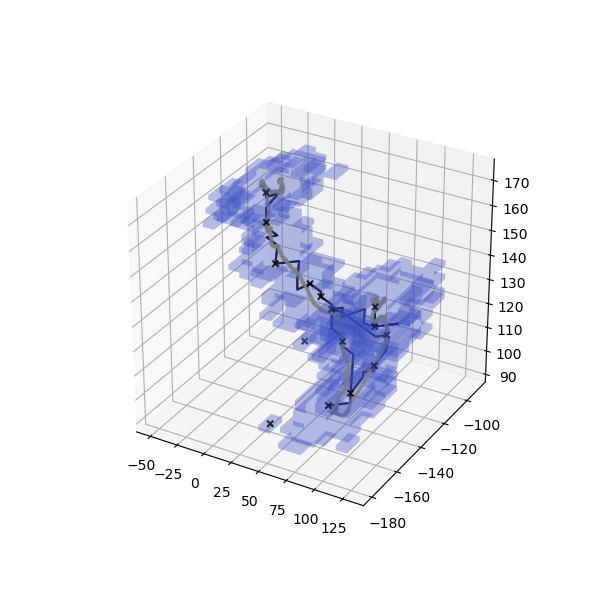

In [182]:
plt.figure(figsize = (6, 6))
pltclouds.draw_cloud(cells, bins, df);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.5, c = 'gray');

## MC 

In [183]:
dft = mcclouds.mctrue(bins, mask, cells, df, mccoors, mcene, mctime,  mcid)


<IPython.core.display.Javascript object>


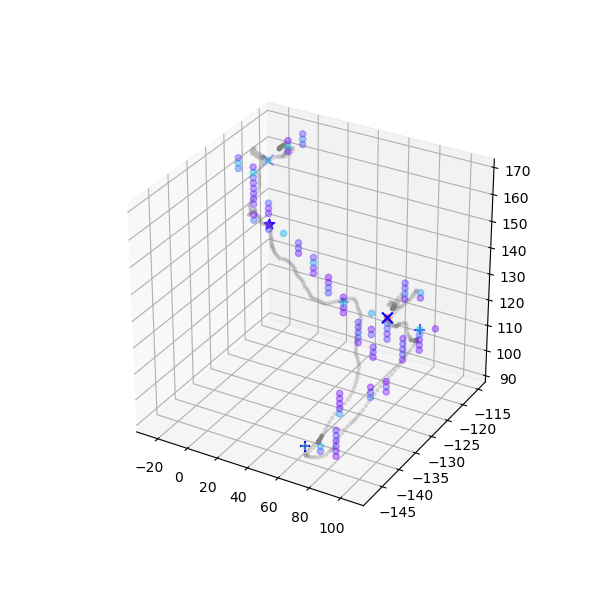

In [190]:
cells_select = clouds.cells_select
ismc         = dft.mc       .values
cene         = dft.mcene    .values
ctime        = dft.mctime   .values
cmcid        = dft.mcid     .values
uextr        = dft.mcextreme.values

plt.figure(figsize = (6, 6))
ax = plt.gca(projection = '3d')
ax.scatter(*cells_select(cells, ismc), c = cene[ismc], alpha = 0.4);
#ax.scatter(*cells_select(cells, ctnodes), marker = '+', c = 'black', s = 60);
#ax.scatter(*cells_select(cells, ctnodes1), marker = 'x', c = 'black', s = 60);
ax.scatter(*cells_select(cells, uextr == 0), marker = '*', c = 'blue', s = 60);
ax.scatter(*cells_select(cells, uextr == 1), marker = 'x', c = 'blue', s = 60);
ax.scatter(*cells_select(cells, uextr > 1), marker = '+', c = 'blue', s = 60);

#pltclouds.draw_grad(cells, epath, alpha = 0.8);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

In [192]:
print(ismc[np.argwhere(uextr >= 0)])
print(cene[np.argwhere(uextr == 0)])
print(cene[np.argwhere(uextr == 1)])
print(cmcid[np.argwhere(uextr == 0)])
print(cmcid[np.argwhere(uextr == 1)])
print(ctime[np.argwhere(uextr == 0)])
print(ctime[np.argwhere(uextr == 1)])

[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]
[[0.00971047]]
[[0.08668308]
 [0.21810043]]
[[1.33333333]]
[[1.]
 [2.]]
[[0.00481155]]
[[0.37578892]
 [0.88181825]]


## Time graph

<IPython.core.display.Javascript object>


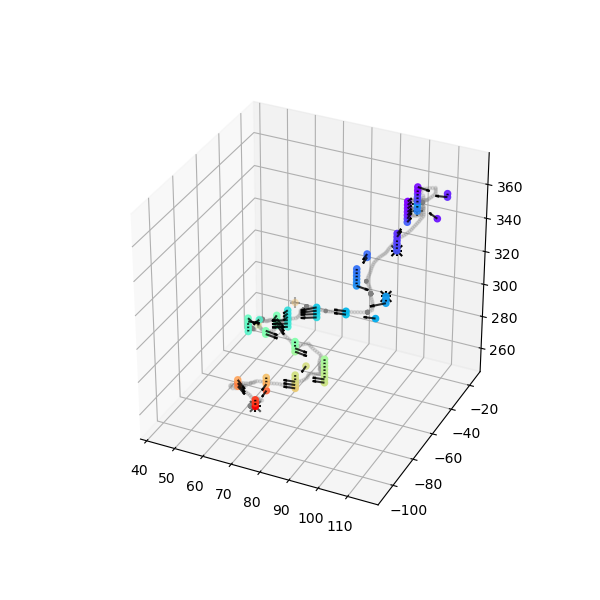

In [130]:
cells_select = clouds.cells_select
ctime   = dft.mctime.values
ctnodes = dft.mctimeextr.values >= 0
ctnodes1 = dft.mctimeextr.values == 1

plt.figure(figsize = (6, 6))
ax = plt.gca(projection = '3d')
ax.scatter(*cells, c = ctime);
ax.scatter(*cells_select(cells, ctnodes), marker = '+', c = 'black', s = 60);
ax.scatter(*cells_select(cells, ctnodes1), marker = 'x', c = 'black', s = 60);
pltclouds.draw_grad(cells, epath, alpha = 0.8);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

In [74]:
print('degrees ', degrees)
print('nlink \n', nlink)

degrees  [1 2 1 2]
nlink 
 [[ -1  -1  -1 561]
 [ -1  -1 500 559]
 [ -1 426  -1  -1]
 [560 560  -1  -1]]


In [47]:
for name in ('mceneextr', 'mctimeextr'):
    vals = dft[name].values
    print(name[:5], ' nodes total  ', np.sum(vals > 0))
    print(name[:5], ' nodes iso    ', np.sum(vals == 0))
    print(name[:5], ' nodes single ', np.sum(vals == 1))
    print(name[:5], ' nodes chain  ', np.sum(vals >  1))

mcene  nodes total   12
mcene  nodes iso     0
mcene  nodes single  1
mcene  nodes chain   11
mctim  nodes total   3
mctim  nodes iso     0
mctim  nodes single  2
mctim  nodes chain   1


In [23]:
node, epath, isnode  = graphs._emap(bins, mask, cells, ctime)

In [29]:
pltclouds.draw_grad(cells, epath);

In [196]:
np.sum(dft.mceneextr.values >0)

22

## All nodes

<IPython.core.display.Javascript object>


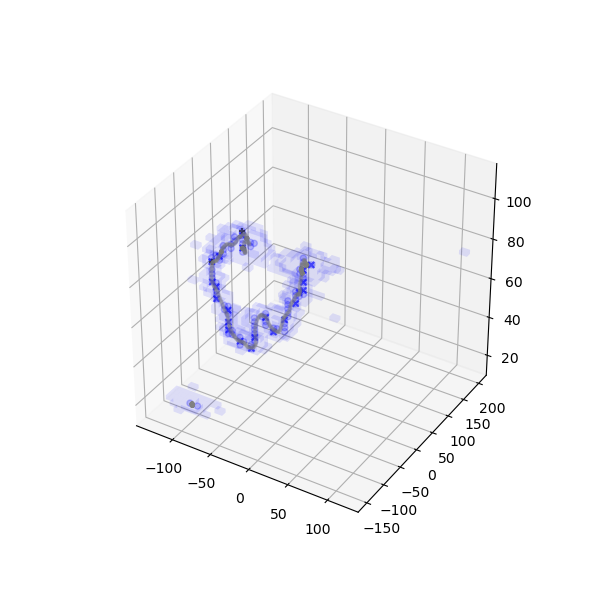

In [197]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
istrue = dft.ismc.values
plt.gca().scatter(*cells_select(cells, istrue), marker = 'o', alpha = 0.2);
eisext = dft.mceneextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = 'x', alpha = 0.6, c = 'blue');
eisext = dft.mctimeextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = '+', alpha = 0.6, c = 'black');
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

## Nodes with 1 degree

In [198]:
for name in ('mceneextr', 'mctimeextr'):
    vals = dft[name].values
    print(name[:5], ' nodes total  ', np.sum(vals > 0))
    print(name[:5], ' nodes iso    ', np.sum(vals == 0))
    print(name[:5], ' nodes single ', np.sum(vals == 1))
    print(name[:5], ' nodes chain  ', np.sum(vals >  1))

mcene  nodes total   22
mcene  nodes iso     1
mcene  nodes single  4
mcene  nodes chain   18
mctim  nodes total   3
mctim  nodes iso     4
mctim  nodes single  2
mctim  nodes chain   1


<IPython.core.display.Javascript object>


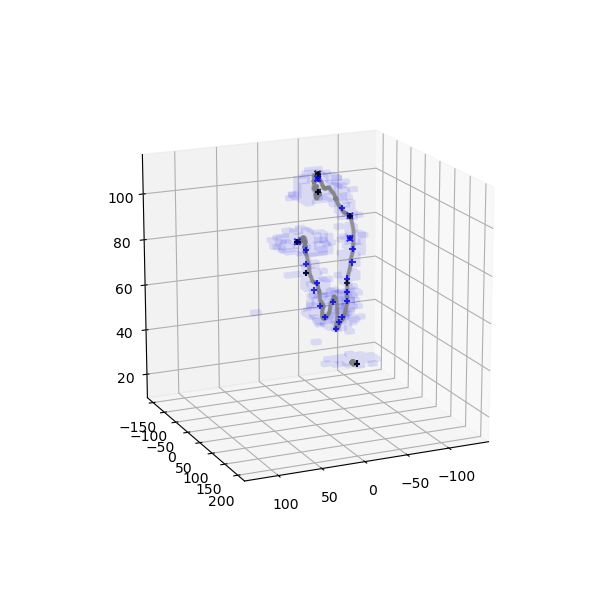

In [199]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
for k, name in enumerate(('mcene', 'mctime')):
    vals = dft[name+'extr'].values
    for i, isel in enumerate((vals >= 0, vals == 1)):
        c  = 'blue' if k == 0 else 'black'
        mk = '+'    if i == 0 else 'x' 
        plt.gca().scatter(*cells_select(cells, isel), marker = mk, alpha = 0.8, c = c);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.4, c = 'gray');

## Properties of the extremes

<IPython.core.display.Javascript object>


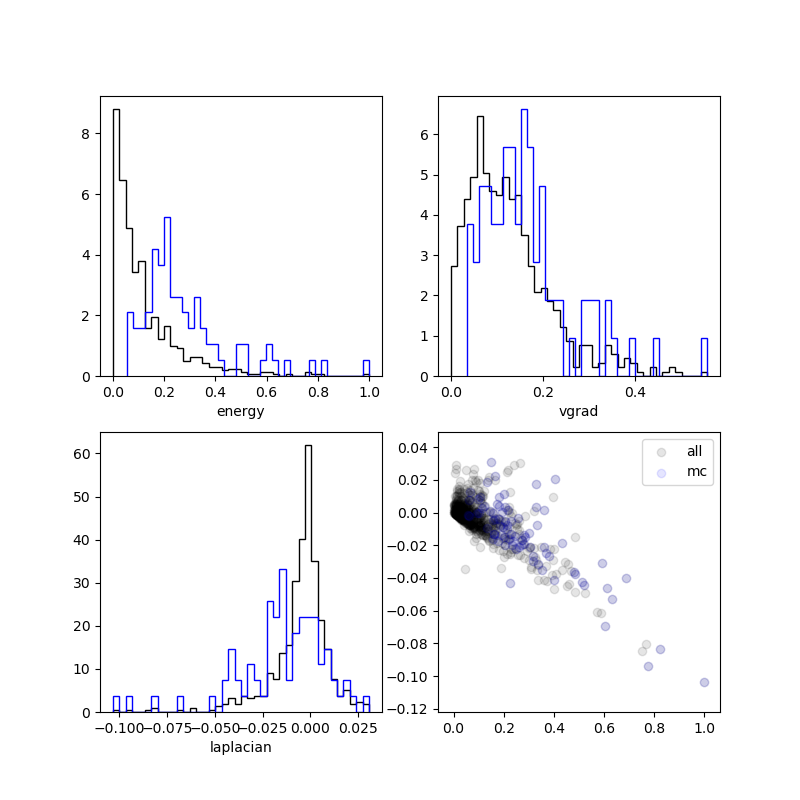

In [188]:
isall   = dft.ismc      .values >= 0
ismc    = dft.ismc      .values
isxextr = dft.mceneextr .values > 0
istextr = dft.mctimeextr.values > 0

plt.figure(figsize = (8, 8));

nbins   = 40
density = True
for isel, name in zip([isall, ismc], ('all', 'mc', 'xextr', 'textr')):
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.1, label = name)
plt.legend()

<IPython.core.display.Javascript object>


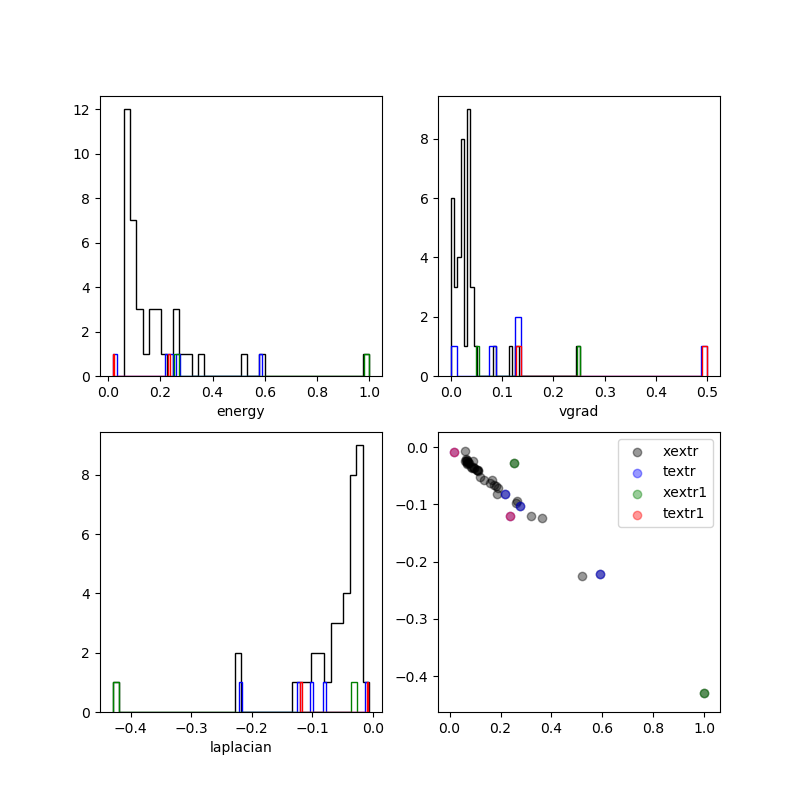

In [178]:
isxextr  = dft.mceneextr .values  >=0
istextr  = dft.mctimeextr.values  >=0
isxextr1 = dft.mceneextr .values  == 1
istextr1 = dft.mctimeextr.values  == 1

plt.figure(figsize = (8, 8));

nbins   = 40
density = False
for isel, name in zip([isxextr, istextr, isxextr1, istextr1], ('xextr', 'textr', 'xextr1', 'textr1')):
    if (np.sum(isel) <= 0): continue
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.4, label = name)
plt.legend()